This tutorial is based on the textbook here: https://lukas-snoek.com/NI-edu/fMRI-introduction/week_1/python_for_mri.html

# Working with fMRI data
In this tutorial we will continue to look at how to interact with *Nifti* files using the Python package *Nibabel*. We assume that you have experience with basic Python syntax and Numpy and Matplotlib functionality. If not, please consult [this page](https://lukas-snoek.com/NI-edu/other/python_recap.html) for an overview of resources.

**What you'll learn**: after this week's lab ... 

* you know how to load, manipulate, and analyze functional Nifti-files

**Estimated time to complete**: 1-2 hours

## What is "nifti"?
Usually, every scanner manufacturer (Philips, Siemens, GE, etc.) have their own proprietary data format. At Aarhus University Hospital, we have Siemens scanners, and the data is exported as dicom files. However, to streamline the development and use of neuroimaging software packages, the Neuroimaging InFormatics Technology Initiative came up with a new, standardized format, *nifti*, that most neuroimaging packages should support. As such, usually the first step in any (f)MRI preprocessing pipeline is to convert the scanner-specific files (e.g., PAR/RECs) to nifti. This is beyond the scope of this course, but if at one point you need to do this yourself, we highly recommed the [dcm2niix](https://github.com/rordenlab/dcm2niix) package!

Throughout these tutorials you'll work with these nifti-files (also called nifti images), which you can recognize by their extension of *.nii* or its compressed version *.nii.gz*. This file-format is supported by most neuroimaging software packages. 

However, we'd like to inspect and analyze nifti images in Python as well! *Nibabel* is an awesome Python package that allows us to read and load nifti images, and convert them to numpy arrays in a straightforward manner.

In [2]:
# importing modules
import os
import pip
os.system('python3 -m pip install dicom2nifti')
os.system('python3 -m pip install nibabel')
os.system('python3 -m pip install nilearn')
os.system('python3 -m pip install scipy')
os.system('python3 -m pip install matplotlib')

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 895.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.0 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 39.4 MB/s eta 0:00:00
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


0

In [3]:
# Let's load some other packages we need
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib # common way of importing nibabel

We'll load in an example anatomical MRI scan (`anat.nii.gz`) from the current directory using nibabel below:

In [4]:
mri_file = 'data/anat.nii.gz'
img = nib.load(mri_file)

Note the type of `img`: the `Nifti1Image` class. This is a custom class just like a Numpy array, with its own attributes and methods!

In [5]:
print(type(img))

<class 'nibabel.nifti1.Nifti1Image'>


For example, one attribute of `Nifti1Image` objects is the `shape` (which is similar to the numpy array attribute with the same name):

In [6]:
print(img.shape)

(240, 240, 220)


Here, the `shape` attribute is telling us that this is a 3D (anatomical) scan and has 240 voxels in the first dimension, 240 voxels in the second dimension, and 220 voxels in the third dimension.

## The three parts of nifti images
Nifti images can be roughly divided into three "parts":
1. The header with metadata;
2. The image data;
3. The affine matrix

All three parts are of course represented in nibabel's `Nifti1Image` class. Let's go through them one by one.

### The header
The header of nifti files contain metadata about the scan, such as the units of measurement, the voxel size, etc. In `Nifti1Images`, the header is an attribute:

In [7]:
# here, we're storing the header attribute in a new variable, hdr, for easy of use
hdr = img.header

Perhaps confusingly, the header is a custom object (a `Nifti1Header` object) as well, with its own methods and attributes. For example, it has a method called `get_zooms()`, which returns the voxel size (and optionally the sampling rate, if it's a fMRI file):

In [8]:
hdr.get_zooms()  # it's a 1x1x1 mm MRI file!

(1.0, 1.0, 1.0)

Another useful method is the `get_xyzt_units` which returns the units of the measurements (here: voxel size in millimeter and time in seconds):

In [10]:
hdr.get_xyzt_units()

('mm', 'sec')

Let's also load in a functional MRI file (`func.nii.gz`) to see the difference with an anatomical MRI file:

In [11]:
fmri_file = 'data/func.nii.gz'
f_img = nib.load(fmri_file)
print(f_img.shape)
print(f_img.header.get_zooms())
print(f_img.header.get_xyzt_units())

(80, 80, 44, 50)
(2.7, 2.7, 2.97, 0.7)
('mm', 'sec')


In case of fMRI files, the fourth dimension (almost) always represents the "time" dimension. So you can assume that a nifti image of an fMRI file has 4 dimensions, with the first three being the spatial dimensions (similar to the anatomical MRI file: $X \times Y \times Z$) and the last (fourth) being the time dimension ($T$).

So for the above file, you can assume that it has 50 timepoints and has a sampling rate of 0.7 seconds (i.e., a new volume was scanned every 0.7 seconds).

Moreover, you can infer that this file contains data from $80 \times 80 \times 44$ voxels with dimensions $2.7 \times 2.7 \times 2.97$ (in millimeters). To be honest, in practice, you won't deal a lot with the header (as you are generally aware of the dimensions/units of your data), so let's look at the *actual* data!

### The data
When we loaded in the data and created a `Nifti1Image` object, we actually didn't load in the *actual* data (i.e., voxel intensities) in memory yet! This is postponed because it's quite a memory-intensive operation: remember, loading in an fMRI scan with dimensions $80 \times 80 \times 44 \times 50$ is effectively loading in over 14 million numbers (which is, in this case, more than 50MB in size)! By postponing loading the data, you can, for example, peek at the image dimensions without loading all the data in memory.

Anyway, to actually load in the data, you can call the `get_fdata()` method, which will return a numpy array with the same dimensions as the image data. We'll take a look at the anatomical MRI data (`anat.nii.gz`):

In [12]:
img_data = img.get_fdata()
print(type(img_data))  # it's a numpy array!
print(img_data.shape)

<class 'numpy.ndarray'>
(240, 240, 220)


Okay, so `img_data` is a 3D numpy array with ... what exactly? Let's check it out:

In [13]:
print(img_data)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


It's just a bunch of numbers! This is important to remember: **like any image (like your standard png, jpeg, or gif), MRI scans are also just (3D or 4D) arrays of numbers**! The higher the number, the more signal the scanner recorded at that voxel. (It's actually a little more complex than this, but that's beyond the scope of this course!) 

Often, the absolute value of the signal intensities is not necessarily most or only important thing. The *relative differences* between different voxels in space or within voxels across time is also important. For example, for anatomical scans, apart from a high overall signal intensity, you often want a good *contrast* between white and gray matter (i.e., different signal intensities between voxels in these two tissue types). For functional MRI, apart from a clear tissue contrast and a high overall signal intensity, you often also want little (non-experimentally related) differences in signal intensity within a voxel across time.

Anyway, when we printed this 3D array (of $240 \times 240 \times 220$), the notebook chose not to display all 12,672,000 numbers but instead truncated it. The reason it only printed zeros is because the first and last couple of numbers in each dimension likely doesn't contain any (signal related to) brain, just empty space!

So, let's index a small $3 \times 3 \times 3$ patch of voxels in the middle of the brain to check what values these voxels contain:

In [14]:
mid_vox = img_data[118:121, 118:121, 108:111]
print(mid_vox)

[[[61978.4609375  49358.4140625  60996.90234375]
  [67727.59375    49498.63671875 55808.66015625]
  [72775.6171875  49077.96875    51041.0859375 ]]

 [[65484.03125    50199.75       54827.1015625 ]
  [71653.828125   50199.75       55107.546875  ]
  [75299.625      50760.640625   55387.9921875 ]]

 [[78524.75       51882.421875   51321.53125   ]
  [82310.765625   56229.328125   47815.9609375 ]
  [84694.546875   59594.67578125 41646.16015625]]]


That's better! The exact values are not necessarily directly interpretable, i.e., you cannot say that the value 61978.46 is good (or bad), because the exact *scale* of the signal intensities (whether it goes from 0-100 or from 0-100,000) depends on the specific scanner hardware and specific nifti conversion software.

Like any image, (f)MRI scans can be visualized by plotting the numbers and assigning colors to the numbers. Often we visualize brain images in black and white, with higher signal intensities being brighter and lower signal intensities being darker. Importantly, remember that our data here cannot directly be plotted as a (2D) image, because our data (an anatomical scan) is 3D! However, we *can* just plot a single *slice* of the 3D volume, for example, the middle slice of our first voxel axis:

In [15]:
mid_slice_x = img_data[119, :, :]
print(mid_slice_x.shape)

(240, 220)


We can use matplotlib to plot this slice as an image using the `imshow` function you have seen before:

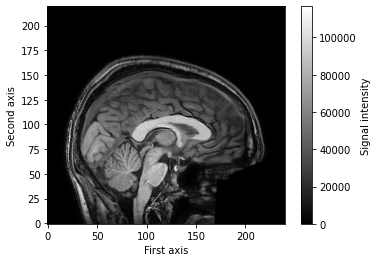

In [16]:
# Note that the transpose the slice (using the .T attribute).
# This is because imshow plots the first dimension on the y-axis and the
# second on the x-axis, but we'd like to plot the first on the x-axis and the
# second on the y-axis. Also, the origin to "lower", as the data was saved in
# "cartesian" coordinates.
plt.imshow(mid_slice_x.T, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()

So far, we have only looked at *structural* (3D) MRI data. This course is mainly about analyzing *functional* data, so let's look at the data from an fMRI scan. We'll use the `Nifti1Image` object `func_img` from before. We'll load the memory with the `get_fdata` method. Note that this takes a little longer than loading in the structural data, because instead of ($240 \times 240 \times 220 = $) 12,672,000 datapoints, we're loading in ($80 \times 80 \times 44 \times 50 =$) 97,715,200 datapoints!

In [17]:
f_img_data = f_img.get_fdata()
print(f_img_data.shape)

(80, 80, 44, 50)


Now, you can think about this 4D array as a series of 3D arrays (volumes), in which the fourth dimension represents time (as shown in the image below).
<br><br>

![img](https://raw.githubusercontent.com/nilearn/nilearn/main/doc/images/niimgs.jpg)

*Source: [nilearn website](https://nilearn.github.io/_images/niimgs.jpg)*

These separate 3D arrays (from the first three dimensions) in fMRI files are often called "volumes" or "dynamics". So, for example, the first volume refers to the first 3D array that was recorded.

Just like the anatomical MRI data, the values in the fMRI data just represent numbers:

In [18]:
# printing a small 3x3x3 volume of voxels from the first timepoint
print(f_img_data[38:41, 38:41, 20:23, 0])

[[[52805.65625    60819.890625   20578.92578125]
  [57084.4453125  55794.015625   17047.22851562]
  [55318.59375    54130.04296875  7301.10351562]]

 [[53111.28515625 43500.99609375 28661.07617188]
  [55488.38671875 49715.421875   20477.04882812]
  [53281.078125   50224.80078125  9304.66210938]]

 [[56846.734375   53756.5        52567.9453125 ]
  [55114.84375    55182.76171875 48798.5390625 ]
  [50055.0078125  56201.51953125 45334.76171875]]]


Again, we can visualize these numbers as images, at least for the first three dimensions, as these represent the spatial dimensions (the fourth dimension represents time). For example, we can visualize a single slice (e.g., $x = 39$) of the first volume ($t = 0$) as follows:

Shape of slice: (80, 44)


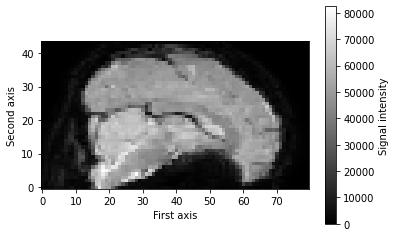

In [19]:
mid_slice_x_fmri = f_img_data[39, :, :, 0]  # x = 39, t = 0
print("Shape of slice: %s" % (mid_slice_x_fmri.shape,))

plt.imshow(mid_slice_x_fmri.T, cmap='gray', origin='lower')
plt.xlabel('First axis')
plt.ylabel('Second axis')
plt.colorbar(label='Signal intensity')
plt.show()

However, we can also look at fMRI data from a different perspective, that is, from the time dimension! For example, we could extract a single voxel's *time series* (i.e., how the signal intensity varies across time) and plot the signal intensity values of that voxel across time. First, let's extract the time series of one particular voxel (e.g., the middle one across all spatial dimensions):

In [20]:
mid_vox_ts = f_img_data[39, 39, 21, :]  # note the ":", saying: give me ALL the timepoints
print("Voxel timeseries shape: %s" % (mid_vox_ts.shape,))

Voxel timeseries shape: (50,)


What we effectively did in the previous cell is to extract the signal intensity at the *same* spatial coordinates ($x=39, y=39, z=21$) across all 50 timepoints. We show this visually in the next cell, where the show the coordinates as a red box across 20 timepoints (not all 50, because that would clutter the notebook too much):

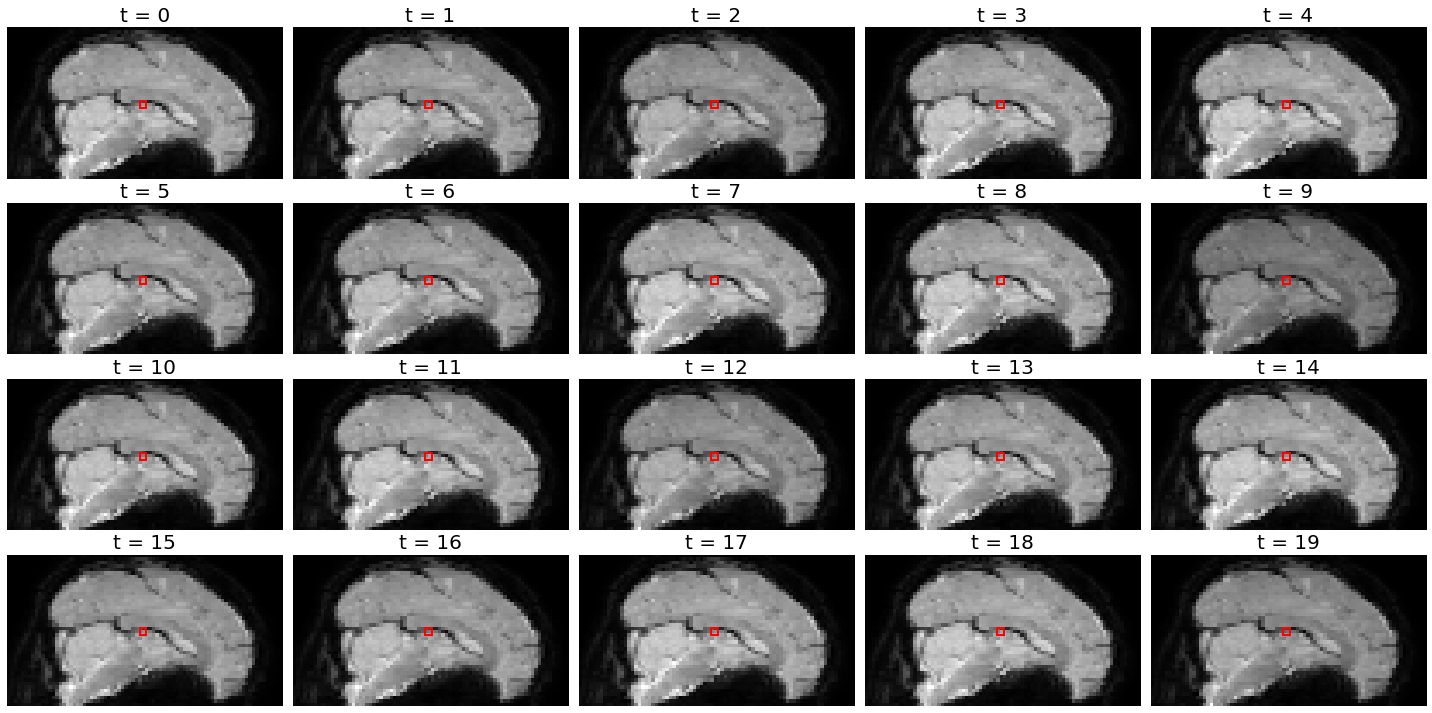

In [21]:
from matplotlib import patches

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(20, 10))  # 20 timepoints
# Loop over the first 20 volumes/timepoints
for t, ax in enumerate(axes.flatten()):    
    ax.imshow(f_img_data[39, :, :, t].T, cmap='gray', origin='lower')  # index with t!
    rect = patches.Rectangle((38, 20), 2, 2, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=20)
fig.tight_layout()

Note that it is *really* hard to spot whether the image of the slice is actually different between different time points! To the naked eye, it just seems like the same image. This is because activity fluctations (over time) in fMRI are **very** small - most of the time just 1-3% compared to baseline (average) activity. That's why it's hard to spot activity differences by looking at the pictures alone (without any scaling).

It's actually easier to see these time-by-time fluctuations in signal intensity by plotting the time series directly:

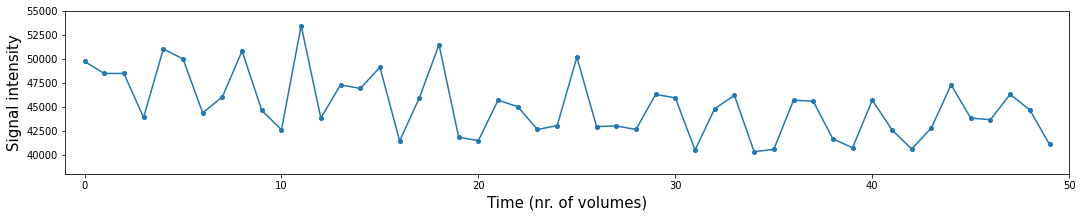

In [22]:
plt.figure(figsize=(18, 3))
plt.plot(mid_vox_ts, 'o-', ms=4)
plt.xlim(-1, mid_vox_ts.size)
plt.ylim(38000, 55000)
plt.ylabel('Signal intensity', fontsize=15)
plt.xlabel('Time (nr. of volumes)', fontsize=15)
plt.show()

In the plot above, the blue dots are the signal intensity values (y-axis), plotted across time (x-axis). The blue lines interconnecting the blue dots are just interpolated values in between the different datapoints (the dots) and serve mostly for visualization purposes (it just looks prettier).

### The affine
Each nifti file contains, in addition to the (meta)data, als an *affine* matrix, which relates the position of the image coordinates to real word coordinates. This may sound vague (it definitely did to us at first!), so let's sketch a scenario in which the image's affine becomes important.

Suppose you were given a nifti file by a colleague (we'll pretend that the `img` variable represents this mysterious nifti file). You have no idea whether it's even a brain scan, so you decide to plot three slices - one from each of the three axes. You pick slice 70 (index 69, because Python is zero-based; first axis), 100 (second axis), and again 100 (third axis).

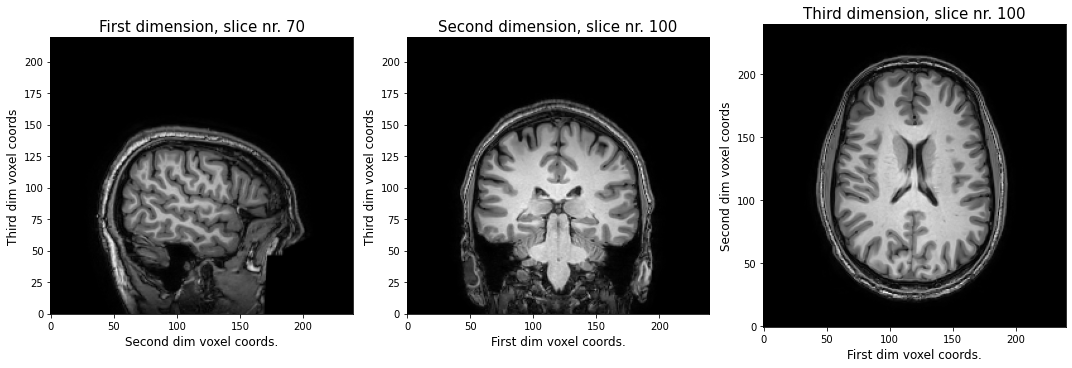

In [23]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

ax[0].imshow(img_data[69, :, :].T, origin='lower', cmap='gray')
ax[0].set_xlabel('Second dim voxel coords.', fontsize=12)
ax[0].set_ylabel('Third dim voxel coords', fontsize=12)
ax[0].set_title('First dimension, slice nr. 70', fontsize=15)

ax[1].imshow(img_data[:, 99, :].T, origin='lower', cmap='gray')
ax[1].set_xlabel('First dim voxel coords.', fontsize=12)
ax[1].set_ylabel('Third dim voxel coords', fontsize=12)
ax[1].set_title('Second dimension, slice nr. 100', fontsize=15)

ax[2].imshow(img_data[:, :, 99].T, origin='lower', cmap='gray')
ax[2].set_xlabel('First dim voxel coords.', fontsize=12)
ax[2].set_ylabel('Second dim voxel coords', fontsize=12)
ax[2].set_title('Third dimension, slice nr. 100', fontsize=15)

fig.tight_layout()

Alright, so, you figured out it's definitely a (structural) MRI scan.You can clearly see that the first voxel axis represents the sagittal dimension (left &larr;&rarr; right), the second voxel axis represents the coronal dimension (anterior &larr;&rarr; posterior), and the third voxel axis represents the axial dimension (inferior &larr;&rarr; superior).

So far, so good!

Now, if we were to ask you: "In the first plot, are we looking at the left or right side of the brain?" Due to the left-right symmetry of the brain, this is actually impossible to tell! As such, we need a way to tell what is left and right (and anterior/posterior and inferior/superior) in our voxel space - this is what the affine is for! It will tell us, basically, whether "left" in our "voxel space" is also "left" in the "real world".

Here, the real world space refers to the position of the voxels (in millimeters) *relative to the isocenter of the scanner*. In this world space, the coordinate $(0, 0, 0)$ refers to the isocenter (see image below). Furthermore, nibabel `Nifti1Images` assume that the first axis goes from left to right, the second axis goes posterior to anterior, and the third axis from inferior to superior. A short-hand for this convention is *RAS+*, which basically says that coordinates to the Right, Anterior, and Superior of the isocenter should be positive (+). It follows that coordinates to the left, posterior, and inferior of the isocenter should be negative (-).

![img](http://www.grahamwideman.com/gw/brain/fs/coords/FSCoords_RAS01.gif)
(Source: Graham Wideman, [link](http://www.grahamwideman.com/gw/brain/fs/coords/fscoords.htm))

Alright, but how does the affine help us recover the real word coordinates of our voxels? It turns out you only need a simple matrix operation: for a set of voxel coordinates $(i, j, k)$, appended with a single 1, and an $4 \times 4$ affine matrix $A$, you can get the real word coordinates (in RAS+) by the dot product (matrix multiplication) of $A$ and $(i, j, k, 1)$:

\begin{align}
\begin{bmatrix} x & y & z & 1 \end{bmatrix} = A\begin{bmatrix}
           i \\
           j \\
           k \\
           1
         \end{bmatrix}
\end{align}

So, our image's affine should be a $4 \times 4$ matrix. Let's see whether that's the case. The affine of a `Nifti1Image` is an attribute named, well, `affine`, and is a 2D numpy array:

In [24]:
np.set_printoptions(suppress=True, precision=3)  # suppresses scientific notation
A = img.affine
print(A)

[[  -0.999   -0.035   -0.006  122.245]
 [  -0.035    0.997    0.066 -117.457]
 [  -0.004   -0.066    0.998  -51.112]
 [   0.       0.       0.       1.   ]]


Now, suppose that you want to know whether the sagittal slice from the leftmost plot in the previous figure is on the left side or the right side. So we want to know the real world $x$ coordinate for our voxel coordinate $i=69$. Let's pick the middle voxel index for our other two dimensions ($j=119, k=109$) (we're plotting this 3D coordinate below in red).

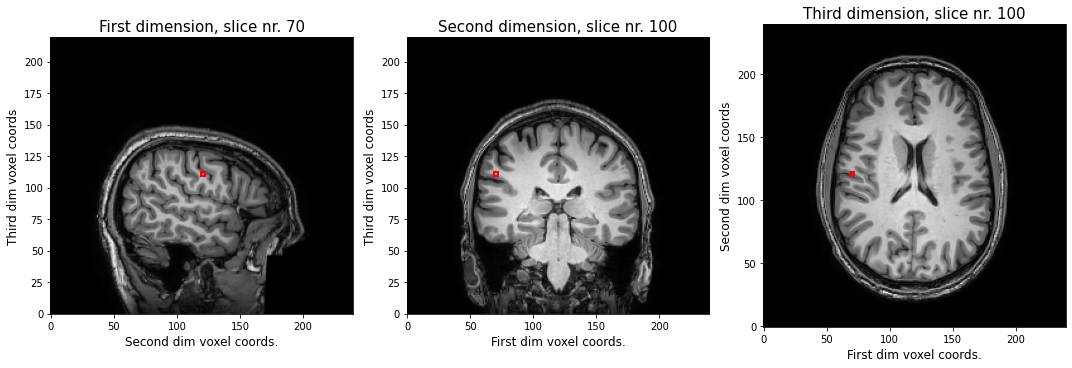

In [26]:
import matplotlib.patches as patches
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

ax[0].imshow(img_data[69, :, :].T, origin='lower', cmap='gray')
ax[0].set_xlabel('Second dim voxel coords.', fontsize=12)
ax[0].set_ylabel('Third dim voxel coords', fontsize=12)
ax[0].set_title('First dimension, slice nr. 70', fontsize=15)
rect = patches.Rectangle((119, 109), 3, 3, linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)

ax[1].imshow(img_data[:, 99, :].T, origin='lower', cmap='gray')
ax[1].set_xlabel('First dim voxel coords.', fontsize=12)
ax[1].set_ylabel('Third dim voxel coords', fontsize=12)
ax[1].set_title('Second dimension, slice nr. 100', fontsize=15)
rect = patches.Rectangle((69, 109), 3, 3, linewidth=2, edgecolor='r', facecolor='none')
ax[1].add_patch(rect)

ax[2].imshow(img_data[:, :, 99].T, origin='lower', cmap='gray')
ax[2].set_xlabel('First dim voxel coords.', fontsize=12)
ax[2].set_ylabel('Second dim voxel coords', fontsize=12)
ax[2].set_title('Third dimension, slice nr. 100', fontsize=15)
rect = patches.Rectangle((69, 119), 3, 3, linewidth=2, edgecolor='r', facecolor='none')
ax[2].add_patch(rect)

fig.tight_layout()

To get the real world coordinate, we need to evaluate the following:
\begin{align}
x, y, z, 1 = A\begin{bmatrix}
           69 \\
           119 \\
           109 \\
           1
         \end{bmatrix}
\end{align}

Let's do that below:

In [27]:
xyz1 = A @ np.array([69, 119, 109, 1])
print(xyz1)

[48.472  5.972 49.516  1.   ]


Here we see that the real world $x$ coordinate is 48.472, which means that this coordinate is 48.472 millimeters to the *right* of the isocenter (remember *RAS+*!).

So, why is this important, you might ask? Well, actually, for your statistical analysis, it doesn't! The general linear model (GLM), which we'll use as our main statistical workhorse in this course, doesn't care whether a voxel is on the left or right side of the brain. But when it comes to visualization and reporting, it does! Suppose that you find unilateral amygdala activity for a particular experimental condition - you want to know whether this is on the left or right side, both for your figures and for your paper that you might write about it!

Moreover, the affine will become important when we'll talk about realignment of different fMRI volumes (in motion correction) and registration of the fMRI volumes to the structural MRI volume or standard space (which might be in different orientations!), which is the topic of week 4.

    
Alright, almost done! Let's practice some of the skills that you learned in this tutorial! For this assignment, you goal is to <em>plot an histogram of the average activity value across time for all non-zero voxels in the brain</em> from the <tt>f_img_data</tt> array. So, what you have to do is the following:

1. Average the <tt>func_img_data</tt> variable across time (resulting array should by of shape (80, 80, 44)
2. Remove all voxels which are zero (use boolean indexing!)
3. Make a histogram of all the resulting non-zero voxels (make sure the histogram has 50 bins)

We will do this in the code-cell below. Also, we will give the plot sensible labels for the axes.

The resulting histogram should show a "bimodal distribution" of average activity values &mdash; roughly with a peak around $x = 0$ and a peak round $x = 42,000$. 
</div>

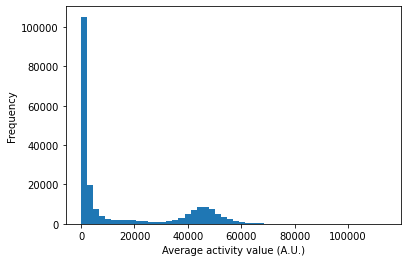

In [28]:

d = f_img_data.mean(axis=-1)
plt.hist(d[d != 0], bins=50)
plt.xlabel('Average activity value (A.U.)')
plt.ylabel('Frequency')
plt.show()


Alright, that's it!

<div class='alert alert-success'>
    <b>Tip</b>: In this notebook, we used several basic Python packages for data processing, analysis, manipulation and plotting (such as numpy, scipy, and matplotlib). We'll make heavy use of this "stack" for the rest of the course. Many procedures we'll discuss in the rest of the course (such as fMRI preprocessing and analysis) can also, and more efficiently, be implemented using <a href="https://nilearn.github.io/">Nilearn</a>, a Python package for fast and easy statistical learning on neuroimaging data.
</div>